In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet("../datasets/queries_with_execution_and_limits_new.parquet.gzip", engine="fastparquet")
df = df[['query', 'execution', 'executed_query']]

In [3]:
df_timeout = df.loc[df['execution'] == 'timeout']
df_fail = df.loc[df['execution'].str.startswith('exception')]
df_empty = df.loc[df['execution'].isnull()]
df_successful = df.drop(df_timeout.index).drop(df_fail.index).drop(df_empty.index)

In [4]:
df_fail

,query,execution,executed_query
index,,,
24,SELECT ?iso ?countryLabel (SUM(?stars) as ?sta...,exception: 500 Server Error: Internal Server E...,SELECT ?iso ?countryLabel (SUM(?stars) as ?sta...
86,SELECT DISTINCT ?person ?personLabel ?personDe...,exception: 400 Client Error: Bad Request for u...,SELECT DISTINCT ?person ?personLabel ?personDe...
341,SELECT ?personLabel ?work ?workLabel ?pubyear ...,exception: 400 Client Error: Bad Request for u...,SELECT ?personLabel ?work ?workLabel ?pubyear ...
413,SELECT ?manufacturer ?manufacturerLabel (SUM(?...,exception: 500 Server Error: Internal Server E...,SELECT ?manufacturer ?manufacturerLabel (SUM(?...
418,"SELECT ?item ?itemLabel\n{\n?item wdt:P2093 ""B...",exception: 400 Client Error: Bad Request for u...,"SELECT ?item ?itemLabel\n{\n?item wdt:P2093 ""B..."
...,...,...,...
2652,SELECT ?item ?articlename ?itemLabel ?itemDesc...,exception: 400 Client Error: Bad Request for u...,SELECT ?item ?articlename ?itemLabel ?itemDesc...
2656,SELECT ?count ?topic ?taxonname\nWITH {\nSELEC...,exception: 400 Client Error: Bad Request for u...,SELECT ?count ?topic ?taxonname\nWITH {\nSELEC...
2760,SELECT DISTINCT ?author ?geo\nWITH {\nSELECT D...,exception: 400 Client Error: Bad Request for u...,SELECT DISTINCT ?author ?geo\nWITH {\nSELECT D...


In [5]:
print(f"Number of timed out requests: {len(df_timeout)}")
print(f"Number of failed requests: {len(df_fail)}")
print(f"Number of empty responses: {len(df_empty)}")
print(f"Number of successful responses: {len(df_successful)}")

Number of timed out request: 222
Number of failed request: 151
Number of empty response: 0
Number of successful resposne: 2472


([<matplotlib.patches.Wedge at 0x1e233721750>,
 [Text(1.0671127277748387, 0.26696521537635426, 'timeout'),
  Text(0.8709913057691959, 0.6718438399468074, 'failed'),
  Text(0.7474052309344161, 0.8070845189767131, 'empty'),
  Text(-1.0080044084249218, -0.44037156197457156, 'success')],
 [Text(0.5820614878771847, 0.14561739020528414, '7.8%'),
  Text(0.4750861667831977, 0.3664602763346222, '5.3%'),
  Text(0.4076755805096815, 0.4402279194418434, '0.0%'),
  Text(-0.5498205864135935, -0.2402026701679481, '86.9%')])

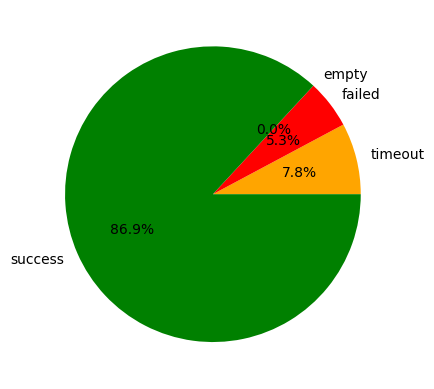

In [127]:
import matplotlib.pyplot as plt


labels = ["timeout", "failed", "empty", "success"]
sizes = [len(df_timeout), len(df_fail), len(df_empty), len(df_successful)]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=["orange", "red", "grey", "green"])

In [6]:
import re

comp = re.compile(r"exception: ([0-9]+)")

def find_error_type(x: pd.Series):
    m = comp.search(x['execution'][:20])
    
    if m != None:
        return m.group(1)
    
    return None

df_fail['error_type'] = df_fail.apply(lambda x: find_error_type(x), axis=1)

distinct_errors = df_fail.error_type.unique()

print(f"There is {len(distinct_errors)} types of errors: {', '.join(map(lambda x: str(x), distinct_errors))}")
for err in distinct_errors:
    if err == None:
        print(f"Number of {str(err)}: {len(df_fail.loc[df_fail['error_type'].isnull()])}")
    else:
        print(f"Number of {str(err)}: {len(df_fail.loc[df_fail['error_type'] == err])}")

print()

for err in distinct_errors:
    if err == None:
        print(f"Example of {str(err)}: {df_fail.loc[df_fail['error_type'].isnull()].iloc[0]['execution']}")
    else:
        print(f"Example of {str(err)}: {df_fail.loc[df_fail['error_type'] == err].iloc[0]['execution']}")

There is 2 types of errors: 500, 400
Number of 500: 40
Number of 400: 111

Example of 500: exception: 500 Server Error: Internal Server Error for url: https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=SELECT+%3Fiso+%3FcountryLabel+%28SUM%28%3Fstars%29+as+%3Fstars%29+%3Ffertility+WHERE+%7B%0A%7BSELECT+DISTINCT+%3Fcountry+%3Fiso+WHERE+%7B%0AVALUES+%3Fcountrytypes+%7Bwd%3AQ6256+wd%3AQ3624078%7D+%23+country+and+sovereign+state%0A%3Fcountry+wdt%3AP31+%3Fcountrytypes+%3B+wdt%3AP298+%3Fiso%0AMINUS+%7B%3Fcountry+wdt%3AP576+%5B%5D%7D+%23+Not+dissolved%0A%7D+%7D%0A%3Fcountry+wdt%3AP163+%3Fflag.%0AOPTIONAL%7B%0A%3Fflag+p%3AP180+%5Bps%3AP180+%3Ffeature+%3B+pq%3AP1114+%3Fstars%5D+.+%23+quantity+of+feature%0A%3Ffeature+wdt%3AP279%3F+wd%3AQ836708+%23+type+of+star+polygon%0A%7D%0AOPTIONAL+%7B+%3Fcountry+wdt%3AP4841+%3Ffertility+%7D%0ASERVICE+wikibase%3Alabel+%7B+bd%3AserviceParam+wikibase%3Alanguage+%22%5BAUTO_LANGUAGE%5D%2Cen%22.+%7D%0A%7D+GROUP+BY+%3Fiso+%3FcountryLabel+%3Ffertility%0AOR

C:\Users\Alexis Strappazzon\AppData\Local\Temp\ipykernel_15400\1239083386.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fail['error_type'] = df_fail.apply(lambda x: find_error_type(x), axis=1)


## Error reasons

Finding more by manually testing queries using the `https://query.wikidata.org`.

### 500 Server Error

A sample of error 500 Server Error found that a lot of (if not all) queries were producing `java.lang.StackOverflowError`.

This can be caused by the complexity or the nature recursive of the queries, but also by a limitation of the utilization of wikidata resources.

### 400 Client Error

Some queries seems to not be correctly formatted like `df_fail.loc[df_fail['error_type'] == '400'].iloc[0]['query']`. Sometimes it is a character that is not properly escaped. Or, data from the crawling that were not deleted.

Some queries are using prefix that are undefined resulting in a malformed query exception.

An other reason, is that the query takes too long too execute and the API endpoint raises a Timeout (different from the `df_timeout` queries; those are timed out by the client).

(This might have been fixed now, but in this version the "LIMIT" clause is added even tho there is already a LIMIT. Some encountered errors were due to that.)

### Some queries broke by the LIMIT clause

#### 1) A closing brackets that works without the LIMIT clause but not with (query index 441)

The closing bracket of the (unexplicit) WHERE is just before the VALUES clause. Which does not allows to add a LIMIT clause. Just moving this brackets to the end of VALUES doesn't only keep the same results but allows for the use of LIMIT.

Problem: I cannot think of a trivial solution to this problem.

```sparql
select ?item ?itemLabel {
?item wdt:P108 ?employer .
filter not exists {
?item ?wdt [] .
?wdt ^wikibase:directClaim/wdt:P31/wdt:P279* wd:Q18614948
}
service wikibase:label {bd:serviceParam wikibase:language "en"}
} values (?employer) {(wd:Q1138080)}
LIMIT 10
```



In [28]:
the_row = 19
print(df_fail.loc[df_fail['error_type'] == '400'].iloc[the_row].name)
print(df_fail.loc[df_fail['error_type'] == '400'].iloc[the_row]['execution'])
print(df_fail.loc[df_fail['error_type'] == '400'].iloc[the_row]['executed_query'])

593
exception: 400 Client Error: Bad Request for url: https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=SELECT+DISTINCT+%3FbiomarkerLabel+%3FproteinLabel+%3FgeneID+%3FWP_gene+%3FPathwayID+%3FPathwayName+%23results+that+are+displayed.%0AWHERE+%7B%0AVALUES+%3Fbiomarker+%7Bwd%3AQ420633+wd%3AQ27125809+wd%3AQ422462%7D+%23you+can+add+more+biomarkers+here+if+needed%2C+separated+by+a+space.%0A%3Fbiomarker+wdt%3AP31+wd%3AQ11173.+%23Stating+that+all+biomarkers+have+to+be+%22instance+of%22+%22chemical+compound%22+%28you+could+ommit+this%2C+but+query+will+probably+take+longer%29.%0A%3Fbiomarker+wdt%3AP638+%3FpdbID+.+%23Checking+if+a+biomarker+has+a+Protein+Databank+ID+%28PDB%29+-%3E+meaning+the+metabolite+can+interact+with+a+protein.%0A%3Fprotein+wdt%3AP31+wd%3AQ8054+.+%23Stating+that+all+proteins+are+%22instance+of%22+%22protein%22%0A%3Fprotein+wdt%3AP638+%3FpdbID+.+%23Checking+which+proteins+have+a+PDB+ID%2C+which+we+queried+previously+in+relationship+to+the+biomarkers.%0A%3Fprotein+

In [111]:
import requests
from requests.exceptions import HTTPError, Timeout
import time
import re

class SPARQLResponse():
    def __init__(self, data) -> None:
        self.data = data
        if isinstance(data, dict):
            if "results" in data and "bindings" in data["results"]:
                self.bindings = data['results']['bindings']
                self.success = True
        else:
            self.bindings = False
            self.success = False

def is_query_empty(query :str) -> bool:
    query = query.strip()
    return query is None or query == "" or len(query) == 0

# Modified from the original file to suit this notebook, but has the same functionality
def send_query_to_api(query, timeout_limit=60, num_try=3):
    response = None
    while num_try > 0 and response == None and not is_query_empty(query):
        try:
            sparql_response = execute_sparql(query, timeout=timeout_limit)
            response = sparql_response.bindings if sparql_response.success else sparql_response.data
                
        except HTTPError as inst:
            if inst.response.status_code == 429:
                retry_after = int(inst.response.headers['retry-after'])
                time.sleep(retry_after + 1)
                num_try -= 1
            else:
                response = "exception: " + str(inst) + "\n" + inst.response.text
        except Timeout:
            response = "timeout"
        except Exception as inst:
            response = "exception: " + str(inst)
    return response if response != None else "exception: too many retry-after"

def execute_sparql(query: str, timeout: int = None):
    url = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql'
    response = requests.get(url, params={'query': query, 'format': 'json'}, headers={'User-agent': 'WikidataLLM bot v0'}, timeout=timeout)
    response.raise_for_status()
    
    try:
        data = SPARQLResponse(response.json())
    except requests.exceptions.JSONDecodeError:
        data = SPARQLResponse(response.text)
    
    return data

def classify_400_errors(stack_trace: str):
    pattern = re.compile(r"Caused by: .+")
    pattern_undefined_prefix = re.compile(r"undefined prefix")
    pattern_parse = re.compile(r"ast.ParseException")
    pattern_limit = re.compile(r"limit|LIMIT")
    pattern_lexical = re.compile(r"Lexical error")
    pattern_non_agg_var_in_sel = re.compile(r"Non-aggregate variable in select expression")
    
    reduced_stack = pattern.findall(stack_trace)
    last_error = reduced_stack[len(reduced_stack)-1]
    
    errors = []
    if pattern_undefined_prefix.search(last_error):
        errors.append("undefined prefix")
    if pattern_parse.search(last_error):
        if pattern_limit.search(last_error):
            errors.append("parse exception due to limit")
        else:
            errors.append("parse exception")
    if pattern_lexical.search(last_error):
        errors.append("lexical error")
    if pattern_non_agg_var_in_sel.search(last_error):
        errors.append("non-aggregate variable in select expression")
        
    return errors

def send_and_classify_400_errors(query: str):
    response = send_query_to_api(query)
    stack = response.split("\n", maxsplit=1)[1]
    return classify_400_errors(stack)
    

In [112]:
df_error400 = df_fail.loc[df_fail['error_type'] == '400'].copy()
df_error400['error_classified'] = df_error400.apply(lambda x: send_and_classify_400_errors(x['executed_query']), axis=1)

| Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured | Calling API... | Exception occured |

,query,execution,executed_query,error_type,error_classified
index,,,,,
86,SELECT DISTINCT ?person ?personLabel ?personDe...,exception: 400 Client Error: Bad Request for u...,SELECT DISTINCT ?person ?personLabel ?personDe...,400,[parse exception]
341,SELECT ?personLabel ?work ?workLabel ?pubyear ...,exception: 400 Client Error: Bad Request for u...,SELECT ?personLabel ?work ?workLabel ?pubyear ...,400,[parse exception]
418,"SELECT ?item ?itemLabel\n{\n?item wdt:P2093 ""B...",exception: 400 Client Error: Bad Request for u...,"SELECT ?item ?itemLabel\n{\n?item wdt:P2093 ""B...",400,[parse exception]
437,SELECT ?item ?itemLabel ?artist ?artistLabel\n...,exception: 400 Client Error: Bad Request for u...,SELECT ?item ?itemLabel ?artist ?artistLabel\n...,400,[parse exception]
441,select ?item ?itemLabel {\n?item wdt:P108 ?emp...,exception: 400 Client Error: Bad Request for u...,select ?item ?itemLabel {\n?item wdt:P108 ?emp...,400,[parse exception due to limit]
...,...,...,...,...,...
2652,SELECT ?item ?articlename ?itemLabel ?itemDesc...,exception: 400 Client Error: Bad Request for u...,SELECT ?item ?articlename ?itemLabel ?itemDesc...,400,[lexical error]
2656,SELECT ?count ?topic ?taxonname\nWITH {\nSELEC...,exception: 400 Client Error: Bad Request for u...,SELECT ?count ?topic ?taxonname\nWITH {\nSELEC...,400,[undefined prefix]
2760,SELECT DISTINCT ?author ?geo\nWITH {\nSELECT D...,exception: 400 Client Error: Bad Request for u...,SELECT DISTINCT ?author ?geo\nWITH {\nSELECT D...,400,[undefined prefix]


error_classified
[undefined prefix]                               47
[lexical error]                                  36
[parse exception]                                16
[parse exception due to limit]                   11
[non-aggregate variable in select expression]     1
Name: count, dtype: int64


([<matplotlib.patches.Wedge at 0x1e23167b250>,
 [Text(0.2620844974233454, 1.0683219160020787, 'undefined prefix'),
  Text(-0.9447496690304588, -0.5634252948411518, 'lexical error'),
  Text(0.4672299580574495, -0.9958394279669962, 'parse exception'),
  Text(1.0263795279743895, -0.39565776190423696, 'parse exception due to limit'),
  Text(1.0995594530727721, -0.031128911935794378, 'non-aggregate variable in select expression')],
 [Text(0.14295518041273383, 0.5827210450920429, '42.3%'),
  Text(-0.515318001289341, -0.30732288809517366, '32.4%'),
  Text(0.25485270439497243, -0.5431851425274524, '14.4%'),
  Text(0.5598433788951215, -0.2158133246750383, '9.9%'),
  Text(0.5997597016760574, -0.016979406510433295, '0.9%')])

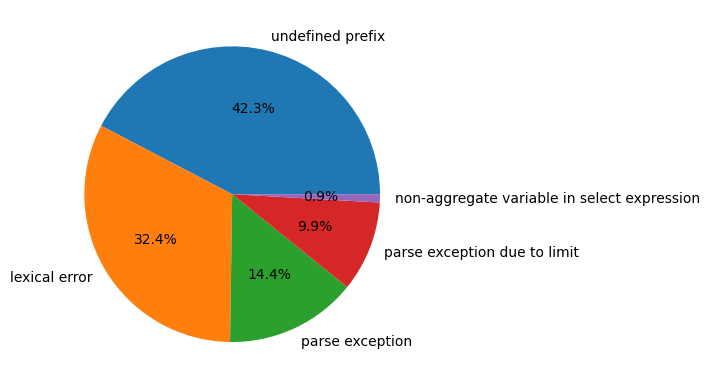

In [125]:
import matplotlib.pyplot as plt

value_counts = df_error400.error_classified.value_counts()
print(value_counts)

labels = list(map(lambda x: x[0], list(df_error400.error_classified.value_counts().index)))
sizes = list(value_counts)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')